<a href="https://colab.research.google.com/github/Mark42Zhong/Just-for-fun/blob/main/Bilateral_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **本科-钟鸿斌-2018053287-实验报告**

实验主题：<br/>
Design a bilateral filter in some programming language (such as C/C++, Matlab, or Python as you like). Using it to process some images, for example, Cameraman, Lena, and so on.


点击代码块左上方运行按钮即可运行代码<br>
第一个代码块需先运行以载入需要的文件<br>
↓

样本图片src_img：


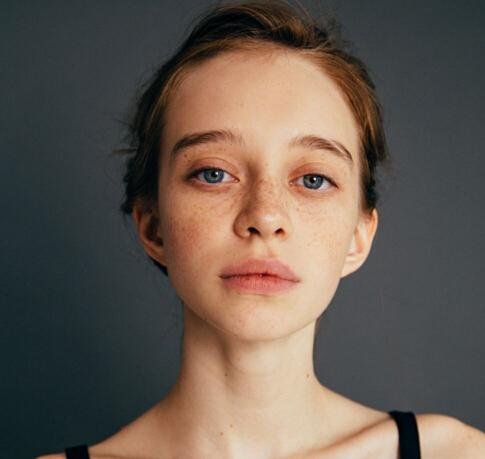

In [76]:
import cv2
import os
import numpy as np
from urllib.request import Request, urlopen
%matplotlib inline

"""
  样本文件夹的创建
  and
  样本图片src_img的导入
"""
def mkdir(path):
  isExist = os.path.exists(path)
  if not isExist:
    os.makedirs(path)
    return True
  else:
    return False

def url_to_img(url):
  hdr = {'User-Agent':'Mozilla/5.0'}
  req = Request(url, headers=hdr)
  response = urlopen(req)
  img_array = np.array(bytearray(response.read()), dtype=np.uint8)
  img = cv2.imdecode(img_array, -1)
  return img

if __name__ == "__main__":
  path = "/tmp/test_img/"
  url = "https://i1.kknews.cc/SIG=28k4ihu/o0r0001rr2418r2rqn4.jpg"
  mkdir(path)
  src_img = url_to_img(url)
  cv2.imwrite("/tmp/test_img/src_img.jpg", src_img)
  print("样本图片src_img：")
  cv2_imshow(src_img)


  


In [ ]:
#bilateral filter
import numpy as np
import cv2
import math
import os
from google.colab.patches import cv2_imshow


def spatial_distance_func(x1, y1, x2, y2, sigma_d):
  """
  该函数用于计算两个像素距离差的高斯函数
  :param
    x1, y1: 中心点的坐标值
    x2, y2: 高斯核内当前遍历点的坐标值
    sigma_d: 坐标空间的sigma参数，该参数较大时，只要颜色相近，越远的像素会相互影响
  :return: 
    距离权重元素
  """
  distance = (x1-x2)**2 + (y1-y2)**2
  return math.exp(-0.5 * distance / (sigma_d ** 2))

def pixel_difference_func(g1, g2, sigma_r):
  """
  该函数用于计算两个像素相似度的高斯函数
  :param
    g1: 中心点的灰度值
    g2: 高斯核内当前便利店的灰度值
    sigma_r: 色彩空间的sigma参数，该参数较大时，各像素邻域内相距较远的颜色会被混合到一起，从而造成更大范围的半相等颜色
  :return: 
    相似度权重元素
  """
  pixel_difference = (g1-g2)**2
  return math.exp(-0.5 * pixel_difference / (sigma_r ** 2))


def bilateral_filter_func(img, diameter, sigma_d, sigma_r):
  """
  双边滤波器函数
  :param
    img: 样本照片
    diameter: 高斯核直径
    sigma_d: 坐标空间的sigma参数，该参数较大时，只要颜色相近，越远的像素会相互影响
    sigma_r: 色彩空间的sigma参数，该参数较大时，各像素邻域内相距较远的颜色会被混合到一起，从而造成更大范围的半相等颜色
  :return: 
    双边滤波后的图片
  """
  new_image = np.zeros(img.shape)

  for row in range(img.shape[0]):
    for col in range(img.shape[1]):
      w_sum = 0
      filter_img = 0
      for k in range(diameter):
        for l in range(diameter):
          n_x =row - ((diameter+1)/2 - k - 1)
          n_y =col - ((diameter+1)/2 - l - 1)
          n_x, n_y = int(n_x), int(n_y)
          #zero padding
          if n_x < 0 or n_x >= img.shape[0] or n_y < 0 or n_y >= img.shape[1]:
            w_sum += 0
            filter_img += 0
            continue
          d = spatial_distance_func(row, col, n_x, n_y, sigma_d)
          r = pixel_difference_func(img[row][col], img[n_x][n_y], sigma_r)
          w = d * r
          w_sum += w
          filter_img = filter_img + img[n_x][n_y] * w
      new_image[row][col] = math.floor(filter_img / w_sum)
  return new_image

def main():
  '''
  算法思路：
    1.将样本图片src_img分割成R、G、B三个通道
    2.分别对三个通道进行双边滤波降噪
    3.将R、G、B三通道合并得到目标图片dst_img
  '''
  src_img = cv2.imread(r"/tmp/test_img/src_img.jpg")
  blue, green, red = cv2.split(src_img)
  imgs = [blue, green, red]

  diameter, sigma_d, sigma_r = 9, 30, 30

  dst_imgs = []
  for img in imgs:
    dst_img = bilateral_filter_func(img, diameter, sigma_d, sigma_r)
    dst_imgs.append(dst_img)
        
  dst_img = cv2.merge(dst_imgs)
  imgs = np.hstack([src_img, dst_img])
  print()
  print("左侧为样本图片src_img    右侧为在RGB空间中进行双边滤波处理后的图片")
  print()
  cv2_imshow(imgs)
  cv2.imwrite("/tmp/test_img/dst_img1.jpg", dst_img)

if __name__ == "__main__":
  main()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in ubyte_scalars


效果还可以接受，但是因为双边滤波包含了值域处理，在RGB空间上操作，很容易造成在同一个像素位置三个通道的去噪强度不一致，导致颜色出现偏差（当sigma_d 和 sigma_r较大时就会出现）。<br>
为了减缓这种现象，可以将颜色空间从RGB转换到HSV空间，不仅可以有效减缓颜色偏差问题，而且效果比在RGB空间更好。<br>
修改后的代码如下。


In [ ]:
#RGB<->HSI空间转换bilateral filter
import numpy as np
import cv2
import math
import os
from google.colab.patches import cv2_imshow


def spatial_distance_func(x1, y1, x2, y2, sigma_d):
  """
  该函数用于计算两个像素距离差的高斯函数
  :param
    x1, y1: 中心点的坐标值
    x2, y2: 高斯核内当前遍历点的坐标值
    sigma_d: 坐标空间的sigma参数，该参数较大时，只要颜色相近，越远的像素会相互影响
  :return: 
    距离权重元素
  """
  distance = (x1-x2)**2 + (y1-y2)**2
  return math.exp(-0.5 * distance / (sigma_d ** 2))

def pixel_difference_func(g1, g2, sigma_r):
  """
  该函数用于计算两个像素相似度的高斯函数
  :param
    g1: 中心点的灰度值
    g2: 高斯核内当前便利店的灰度值
    sigma_r: 色彩空间的sigma参数，该参数较大时，各像素邻域内相距较远的颜色会被混合到一起，从而造成更大范围的半相等颜色
  :return: 
    相似度权重元素
  """
  pixel_difference = (g1-g2)**2
  return math.exp(-0.5 * pixel_difference / (sigma_r ** 2))


def bilateral_filter_func(img, diameter, sigma_d, sigma_r):
  """
  双边滤波器函数
  :param
    img: 样本照片
    diameter: 高斯核直径
    sigma_d: 坐标空间的sigma参数，该参数较大时，只要颜色相近，越远的像素会相互影响
    sigma_r: 色彩空间的sigma参数，该参数较大时，各像素邻域内相距较远的颜色会被混合到一起，从而造成更大范围的半相等颜色
  :return: 
    双边滤波后的图片
  """
  new_image = np.zeros(img.shape)

  for row in range(img.shape[0]):
    for col in range(img.shape[1]):
      w_sum = 0
      filter_img = 0
      for k in range(diameter):
        for l in range(diameter):
          n_x =row - ((diameter+1)/2 - k - 1)
          n_y =col - ((diameter+1)/2 - l - 1)
          n_x, n_y = int(n_x), int(n_y)
          #zero padding
          if n_x < 0 or n_x >= img.shape[0] or n_y < 0 or n_y >= img.shape[1]:
            w_sum += 0
            filter_img += 0
            continue
          d = spatial_distance_func(row, col, n_x, n_y, sigma_d)
          r = pixel_difference_func(img[row][col], img[n_x][n_y], sigma_r)
          w = d * r
          w_sum += w
          filter_img = filter_img + img[n_x][n_y] * w
      new_image[row][col] = math.floor(filter_img / w_sum)
  return new_image

def main():
  '''
  算法思路：
    1.读取照片并将照片从RGB空间转换为HSV空间
    2.将样本图片src_img分割成R、G、B三个通道（准确应该是H, S, V三个通道， 但是鉴于对算法并无影响，所以此处变量仍保持跟上面相同为R、G、B）
    3.分别对三个通道进行双边滤波降噪
    4.将R、G、B三通道合并得到目标图片dst_img
    5.将dst_img从HSV空间转换回RGB空间
  '''
  src_img = cv2.imread(r"/tmp/test_img/src_img.jpg")

  #将图像从RGB空间转换到HSV空间
  src_img = cv2.cvtColor(src_img, cv2.COLOR_RGB2HSV)

  blue, green, red = cv2.split(src_img)
  imgs = [blue, green, red]

  diameter, sigma_d, sigma_r = 9, 30, 30

  dst_imgs = []
  for img in imgs:
    dst_img = bilateral_filter_func(img, diameter, sigma_d, sigma_r)
    dst_imgs.append(dst_img)
        
  dst_img = cv2.merge(dst_imgs)

  #将图像从HSI空间转换回RGB空间
  src_img = cv2.cvtColor(src_img, cv2.COLOR_HSV2RGB)
  dst_img = cv2.cvtColor(dst_img.astype('uint8'), cv2.COLOR_HSV2RGB)

  imgs = np.hstack([src_img, dst_img])
  print()
  print("左侧为样本图片src_img    右侧为在HSV空间中进行双边滤波处理后的图片")
  print()
  cv2_imshow(imgs)
  cv2.imwrite("/tmp/test_img/dst_img2.jpg", dst_img)

if __name__ == "__main__":
  main()

图像处理的效果得到了改善， 但是运行速度惨不忍睹。<br>
为了加速图片处理的速度，可以先把距离高斯函数的模板和相似度高斯函数的模板先计算出来。





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in ubyte_scalars



左侧为src_img  右侧为dst_img



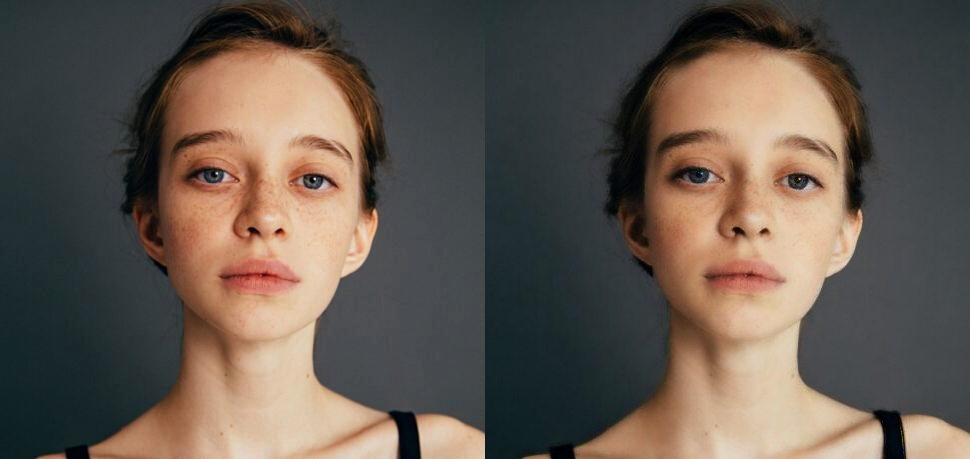

In [77]:
#提前计算模板的RGB<->HSI空间转换bilateral filter
import numpy as np
import cv2
import math
import os
from google.colab.patches import cv2_imshow


def spatial_distance_square(diameter, sigma_d):
  """
  计算距离高斯函数的模板函数
  :param
    diameter: 高斯核直径
    sigma_d: 坐标空间的sigma参数，该参数较大时，只要颜色相近，越远的像素会相互影响
  :return: 
    已经计算好的距离高斯函数值字典
  """
  d_weight = {}
  coefficient = -0.5 / (sigma_d ** 2)
  x, y = diameter // 2, diameter // 2
  for k in range(x+1):
    for l in range(y+1):
      distance = (k-x)**2 + (l-y)**2
      if distance not in d_weight:
        d_weight[distance] = math.exp(distance * coefficient)
  return d_weight
  

def pixel_difference_square(sigma_r):
  """
  计算相似度高斯函数的模板函数
  :param
    sigma_r: 色彩空间的sigma参数，该参数较大时，各像素邻域内相距较远的颜色会被混合到一起，从而造成更大范围的半相等颜色
  :return: 
    已经计算好的相似度高斯函数值字典
  """
  r_weight = {}
  coefficient = -0.5 / (sigma_r ** 2)
  for i in range(256):
    r_weight[i] = math.exp(i * i * coefficient)
  return r_weight


def bilateral_filter_func(img, diameter, sigma_d, sigma_r):
  """
  双边滤波器函数
  :param
    img: 样本照片
    diameter: 高斯核直径
    sigma_d: 坐标空间的sigma参数，该参数较大时，只要颜色相近，越远的像素会相互影响
    sigma_r: 色彩空间的sigma参数，该参数较大时，各像素邻域内相距较远的颜色会被混合到一起，从而造成更大范围的半相等颜色
  :return: 
    双边滤波后的图片
  """
  new_image = np.zeros(img.shape)
  #提前计算好距离模板和相似度模板
  d_weight = spatial_distance_square(diameter, sigma_d)
  r_weight = pixel_difference_square(sigma_r) 

  for row in range(img.shape[0]):
    for col in range(img.shape[1]):
      w_sum = 0
      filter_img = 0
      for k in range(diameter):
        for l in range(diameter):
          n_x =row - ((diameter+1)/2 - k - 1)
          n_y =col - ((diameter+1)/2 - l - 1)
          n_x, n_y = int(n_x), int(n_y)
          #zero padding
          if n_x < 0 or n_x >= img.shape[0] or n_y < 0 or n_y >= img.shape[1]:
            w_sum += 0
            filter_img += 0
            continue
          
          #查询距离模板和相似度模板求出权值w
          distance = (row-n_x)**2 + (col-n_y)**2
          pixel_difference = img[row][col] - img[n_x][n_y]
          w = d_weight[distance] * r_weight[pixel_difference] 
          w_sum += w
          filter_img = filter_img + img[n_x][n_y] * w
      new_image[row][col] = math.floor(filter_img / w_sum)
  return new_image

def main():
  '''
  算法思路：
    1.读取照片并将照片从RGB空间转换为HSV空间
    2.将样本图片src_img分割成R、G、B三个通道（准确应该是H, S, V三个通道， 但是鉴于对算法并无影响，所以此处变量仍保持跟上面相同为R、G、B）
    3.分别对三个通道进行双边滤波降噪
    4.将R、G、B三通道合并得到目标图片dst_img
    5.将dst_img从HSV空间转换回RGB空间
  '''
  src_img = cv2.imread(r"/tmp/test_img/src_img.jpg")

  #将图像从RGB空间转换到HSI空间
  src_img = cv2.cvtColor(src_img, cv2.COLOR_RGB2HSV)

  blue, green, red = cv2.split(src_img)
  imgs = [blue, green, red]

  diameter, sigma_d, sigma_r = 9, 30, 30

  dst_imgs = []
  for img in imgs:
    dst_img = bilateral_filter_func(img, diameter, sigma_d, sigma_r)
    dst_imgs.append(dst_img)
        
  dst_img = cv2.merge(dst_imgs)

  #将图像从HSI空间转换回RGB空间
  src_img = cv2.cvtColor(src_img, cv2.COLOR_HSV2RGB)
  dst_img = cv2.cvtColor(dst_img.astype('uint8'), cv2.COLOR_HSV2RGB)
  imgs = np.hstack([src_img, dst_img])
  print()
  print("左侧为src_img  右侧为dst_img")
  print()
  cv2_imshow(imgs)
  cv2.imwrite("/tmp/test_img/dst_img3.jpg", dst_img)

if __name__ == "__main__":
  main()

In [74]:
#cv2内置bilateralFilter()函数结果
diameter, sigma_d, sigma_r = 9, 30, 30
src_img = cv2.imread(r"/tmp/test_img/src_img.jpg")
dst_img = cv2.bilateralFilter(src_img, diameter, sigma_d, sigma_r)
cv2.imwrite(r"/tmp/test_img/dst_img4.jpg", dst_img)
imgs = np.hstack([src_img, dst_img])
print("左侧为样本图片src_img    右侧为cv2内置函数bilateralFilter()处理后的图片")
cv2_imshow(imgs)

True

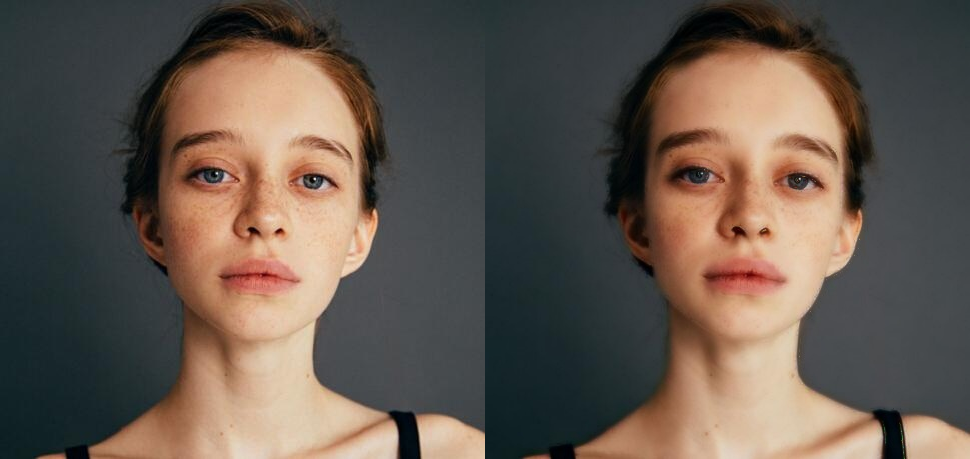

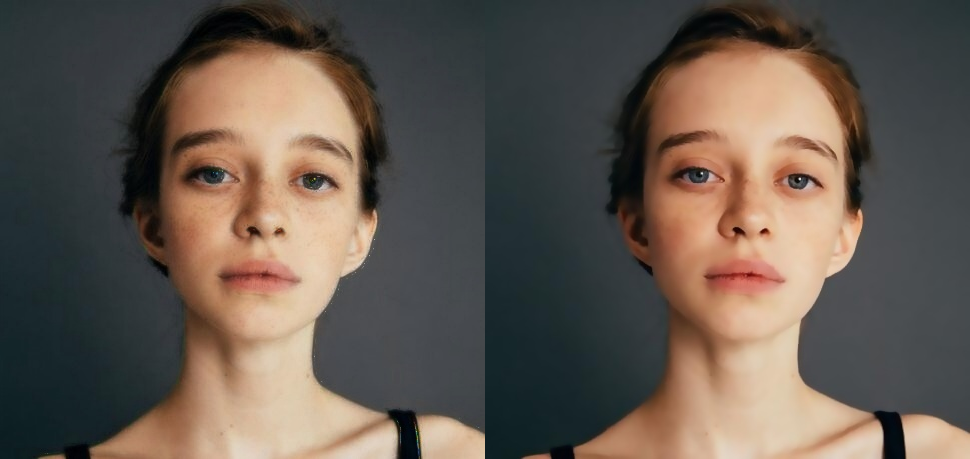

In [75]:
#四个图像的对比
img = cv2.imread(r"/tmp/test_img/src_img.jpg")
img1 = cv2.imread(r"/tmp/test_img/dst_img1.jpg")
img3 = cv2.imread(r"/tmp/test_img/dst_img3.jpg")
img4 = cv2.imread(r"/tmp/test_img/dst_img4.jpg")
imgs1 = np.hstack([img, img1])
cv2_imshow(imgs1)
imgs2 = np.hstack([img3, img4])
cv2_imshow(imgs2)
